# Machine Learning Project - Building a Neural Network to Predict Inner Speech
> ## by Austin Drake and Nele Felicitas Werner

# Overview
The goal of this project is to design a machine learning algorithm capable of predicting the Direction label of an EEG recording from the inner-speech-recognition dataset. The Inner Speech condition is given special significance in training, however the Visualization condition is utilized in some models independently and in a collection with the Inner Speech condition dataset. Three utility scripts are needed to run this model, derived from scripts available on the GitHub repository provided by Nieto et al. (2022): https://github.com/N-Nieto/Inner_Speech_Dataset. The Utility script, Data Extraction script and Data Processing script are required for this notebook.

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import os
import shutil
import mne
import warnings
import datetime

from data_extraction import  Extract_data_from_subject
from data_processing import  Select_time_window, Transform_for_classificator, Split_trial_in_time

from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import TensorBoard
from keras.constraints import max_norm

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn import preprocessing, svm
from scipy.fft import rfft, rfftfreq

np.random.seed(23)

mne.set_log_level(verbose='warning') #to avoid info at terminal
warnings.filterwarnings(action = "ignore", category = DeprecationWarning ) 
warnings.filterwarnings(action = "ignore", category = FutureWarning ) 

# Notes on Data Extraction:

### Parameters
> - Sampling Rate (fs) = 256
> - data type: eeg, exg or baseline
> - T-start: start of window (t=0: focus, t=0.5: arrow, t=1: cue (thinking), t=3.5: rest t=4.5: end)
> - T-end: close of window
> - N_S: subject number (1 through 10)
> - N_B: Session (batch) number

### Extract_subject_from_BDF(root_dir,N_S,N_B):

> Loads raw data for subject and session. Takes the directory pointing to folder containing all recordings
> and preprocessed files, subject number and session/batch number, and returns (raw data, subject number)

### Extract_data_from_subject(root_dir,N_S,datatype):

> Loads all blocks for one subject and stacks results. Takes the directory, calls the file for specified data 
> under the specified subject, and stacks all samples into one object. Also calls the labels. Returns (X,Y): 
> object with stacked trials/samples, and object with correlated labels.

### Extract_block_data_from_subject(root_dir,N_S,datatype,N_B):

> Does the same as above Extract_data_from_subject, but for a specified N_B (batch or session number).
> returns (data samples, labels)

### Extract_report(root_dir,N_B,N_S):

> Pulls report with information regarding the given subject and session. Includes subject age, gender,
> length of recording, count of correct and incorrect answer to control questions, position of contaminated
> trials, mean power for EXG channels 7 & 8, and mean and STD for EXG 7 & 8 baseline recordings.

### Extract_TFR(TRF_dir, Cond, Class, TFR_method , TRF_type):

> Returns Time-Frequency Representation of specified condition and class. 
>
> *Note: location of TRF data unclear, not likely to use in scope of project.*

### Extract_data_multisubject(root_dir, N_S_list, datatype='EEG'):

> Creates a stacked object of all sessions for all listed subjects and returns the stacked trials/samples
> along with a stack of the corresponding labels.

### load_events(root_dir,N_S,N_B):

> Loads the events file to gather the label(s) for dataset using root directory, subject, and batch number.

### Select_time_window(X,t_start=1, t_end=2.5, fs=256):

> Cuts samples to desired time window.

### Transform_for_classificator (X, Y, Classes, Conditions):

> Pulls from the extracted dataset the trials and labels that correspond to the conditions and classes that
> will be used for training and/or testing.


In [2]:
# Load data
root_dir = '/kaggle/input/inner-speech-recognition/inner-speech-recognition'

In [3]:
#We will use subject 1 data as a demonstration, enter your subject of interest under N_S
N_S = 1
datatype = 'eeg'

X, Y = Extract_data_from_subject(root_dir,N_S,datatype)

In [4]:
# Select a time window from t=1.5 to t=3.5
Tstart = 1.5
Tend = 3.5
fs = 256
Subj = Select_time_window(X = X, t_start = Tstart, t_end = Tend, fs = fs)

### Condition Selection
Select the condition(s) that our model will train with

In [5]:
#Use this cell to call data from only the Inner Speech condition
X, Y = Transform_for_classificator(X = Subj, Y = Y, Classes = [['ALL']], Conditions = [['Inner']])

In [6]:
#If Visualization is to be used, run the line below
# X, Y = Transform_for_classificator(X = Subj, Y = Y, Classes = [['ALL']], Conditions = [['Vis']])

# Use this line if training on both Inner Speech and Visualization condition
# X, Y = Transform_for_classificator(X = Subj, Y = Y, Classes = [['ALL', 'ALL']], Conditions = [['Inner', 'Vis']])

In [7]:
#Convert to microvolts
X_resize = X * (10**6)

In [8]:
#We are interested in identifying the direction of the trial, given in the second column of the labels. 
data_labels= Y[:,1]

#For SVM, we will translate the integer labels
trials_dict = {0:'up',
               1:'down',
               2:'right',
               3:'left'}
trial_labels = np.array([trials_dict[direction] for direction in data_labels])
trial_labels.shape

(200,)

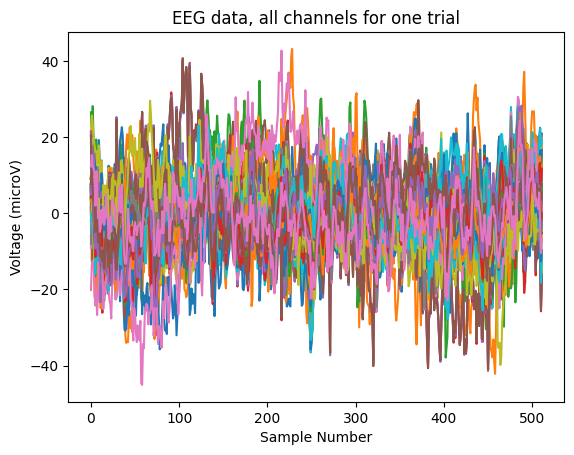

In [9]:
for i in range(X_resize.shape[1]-1):
    plt.plot(X_resize[0,i,:]);
plt.title('EEG data, all channels for one trial')
plt.ylabel('Voltage (microV)')
plt.xlabel('Sample Number')
plt.show()

## FFT
For SVM models, convert the signal into a power spectral density plot and select windows of frequencies that may be significant to our model

In [10]:
#Count the number of samples in each recording, it should be 2sec x 256Hz = 512
N = X_resize.shape[2]
N

512

In [11]:
#Run a FFT on the each channel of each recording, and get frequencies
samples_fft = rfft(X_resize)
samples_freq = rfftfreq(N, 1/fs)
samples_fft.shape

(200, 128, 257)

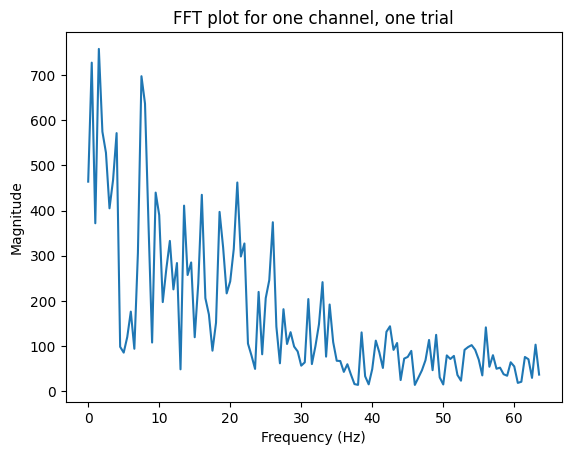

In [12]:
plt.plot(samples_freq[:fs//2], np.abs(samples_fft[0,0,:fs//2]))
plt.title('FFT plot for one channel, one trial')
plt.ylabel('Magnitude')
plt.xlabel('Frequency (Hz)')
plt.show()

In [13]:
#Average the fourier series across channels
avg_fft = np.mean(samples_fft, axis = 1)
avg_fft.shape

(200, 257)

In [14]:
#Calculate Magnitude of frequency, convert to dB
mag_fft = np.sqrt((avg_fft.real ** 2) + (avg_fft.imag ** 2))
db_fft = 20 * np.log10(mag_fft)
db_fft.shape

(200, 257)

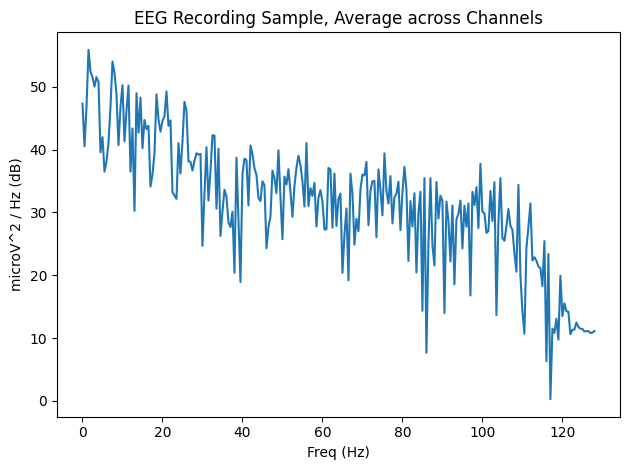

In [15]:
plt.plot(samples_freq, np.abs(db_fft[0,:]))
plt.xlabel('Freq (Hz)')
plt.ylabel('microV^2 / Hz (dB)')
plt.title('EEG Recording Sample, Average across Channels')
plt.tight_layout()
plt.show()

In [16]:
#The FFT has been taken over every half-Hz frequency
print(samples_freq[0:8])

[0.  0.5 1.  1.5 2.  2.5 3.  3.5]


We will now cut a window from 4 to 40 Hz, roughly encompassing the theta wave to low gamma-wave range of frequencies.

In [17]:
data_fft = db_fft[:,8:81]
data_freq = samples_freq[8:81]
print(data_fft.shape, data_freq.shape)
print(data_freq[0],data_freq[-1])

(200, 73) (73,)
4.0 40.0


# 1. SVM Multiclass Model
We will now train a simple SVM model on the selected frequencies from the 1.5-3.5 window of our inner speech data

In [18]:
#Split train and test data
x_train_svm, x_test_svm, y_train_svm, y_test_svm = train_test_split(data_fft, trial_labels, test_size=0.2, shuffle=True)

In [19]:
# Generate demo SVM model
model = svm.SVC()
model.fit(x_train_svm, y_train_svm)

SVC()

In [20]:
#Evaluate the model
predictions = model.predict(x_test_svm)
print(classification_report(y_test_svm, predictions))

              precision    recall  f1-score   support

        down       0.57      0.40      0.47        10
        left       0.20      0.08      0.11        13
       right       0.29      0.20      0.24        10
          up       0.24      0.71      0.36         7

    accuracy                           0.30        40
   macro avg       0.32      0.35      0.29        40
weighted avg       0.32      0.30      0.28        40



## Grid Search
These results are not great, with accuracy around 25%. Lets search for a better model. We will use Grid Search to find the best parameters, and Stratified k-fold Cross-Validation.

In [21]:
param_grid = {'C': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf', 'poly'],
              'degree': [1, 2, 3, 4, 5]
              }
grid = GridSearchCV(svm.SVC(), param_grid, cv=8, refit=True, verbose=1)
grid.fit(x_train_svm, y_train_svm)

Fitting 8 folds for each of 50 candidates, totalling 400 fits


GridSearchCV(cv=8, estimator=SVC(),
             param_grid={'C': [1, 0.1, 0.01, 0.001, 0.0001],
                         'degree': [1, 2, 3, 4, 5], 'kernel': ['rbf', 'poly']},
             verbose=1)

In [22]:
# Find the best parameters for SVM model
print(grid.best_params_)
print(grid.best_estimator_)

{'C': 0.001, 'degree': 3, 'kernel': 'poly'}
SVC(C=0.001, kernel='poly')


In [23]:
#Evaluate the best performing model
grid_predictions = grid.predict(x_test_svm) 
  
# print classification report 
print(classification_report(y_test_svm, grid_predictions)) 

              precision    recall  f1-score   support

        down       0.50      0.50      0.50        10
        left       0.38      0.23      0.29        13
       right       0.29      0.20      0.24        10
          up       0.27      0.57      0.36         7

    accuracy                           0.35        40
   macro avg       0.36      0.38      0.35        40
weighted avg       0.36      0.35      0.34        40



# 2. Implement CNN

This model is derived from two models* used in prior EEG studies, with modifications based on trial and error to improve performance.

* *basic CNN (further details in the final report): Thomas, J., Comoretto, L., Jin, J., Dauwels, J., Cash, S.S., Westover, M.B., 2018. Eeg classification via convolutional neural network-based interictal epileptiform event detection, in: 2018 40th Annual International Conference of the IEEE Engineering in Medicine and Biology Society (EMBC), pp.3148–3151. URL: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6775768/

* *EEGNet: Lawhern, V.J., Solon, A.J., Waytowich, N.R., Gordon, S.M., Hung, C.P., Lance, B.J., 2018. Eegnet: a compact convolutional neural network for eeg-based brain–computer interfaces. Journal of Neural Engineering 15, 056013. URL: http://dx.doi.org/10.1088/1741-2552/aace8c, doi:10.1088/1741-2552/aace8c.


In [24]:
# one-hot encoding is needed for CNN models
y = pd.get_dummies(data_labels)

In [25]:
# Define the size of your input based on window size
input_shape = (X_resize.shape[1],X_resize.shape[2],1)
print(input_shape)

(128, 512, 1)


In [26]:
#Split data into training and test
x_trainval_cnn, x_test_cnn, y_trainval_cnn, y_test_cnn = train_test_split(X_resize, y, stratify = y, test_size=0.1)

#Create separate set for validation
x_train_cnn, x_val_cnn, y_train_cnn, y_val_cnn = train_test_split(x_trainval_cnn, y_trainval_cnn, test_size=0.1)

### Deciding on a kernel size
Lets consider how much information our Conv2D layers can see, from a frequency perspective:

- 1x7: 7 samples / 256 Hz = 0.0273 sec. window, equivalent to period of 36.6 Hz signal
- 1x13: 13 / 256 = 0.0508 sec. window, equivalent to period of 19.7 Hz signal
- 1x21: 21 / 256 = 0.0820 sec. window, equivalent to period of 12.2 Hz signal
- 1x31: 31 / 256 = 0.1211 sec. window, equivalent to period of 8.3 Hz signal

it is clear that there is a logarithmic relationship between the length of the sample and the equivalent signal period that it represents. Therefore, 31 is the largest kernel we will use, roughly equivalent to the upper range of the theta brainwaves, and half the period of a delta brainwave.

In [27]:
def create_cnn(input_shape):
    
    Adam_ = tf.keras.optimizers.Adam(learning_rate=0.001, weight_decay=0.0001)
    # create model - Sequential class, linear stack of layers can be added
    model = models.Sequential()
    # first layer
    model.add(layers.Conv2D(32, kernel_size = (1,31), padding = 'valid', activation='relu', input_shape= input_shape, strides = (1,1)))
    # adds max pooling layer
    model.add(layers.MaxPooling2D(pool_size=(1, 2)))
    # second layer - not included in final version
    # model.add(layers.Conv2D(8, kernel_size = (128,1), padding = 'valid', activation='relu', input_shape= input_shape, strides = (1,1)))    
    # depthwise layer
    model.add(layers.DepthwiseConv2D((128,1), padding = 'valid', activation='relu'))
    # adds max pooling layer - not included in final version
    # model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    # flatten output before last convolutional layer
    model.add(layers.Flatten())
    # Add a fully connected layer 
    model.add(layers.Dense(200, activation='relu')) 
    # Add Dropout for regularization
    model.add(layers.Dropout(0.5)) # 0.2 is the default
    # Add a second fully connected layer 
    model.add(layers.Dense(50, activation='relu')) 
    # Add Dropout for regularization
    model.add(layers.Dropout(0.5))
    # Output layer 
    model.add(layers.Dense(4, activation='softmax'))

    # Compile model
    model.compile( 
        optimizer = Adam_, # for CV: switch to 'adam'
        loss = 'categorical_crossentropy',
        metrics = ['accuracy'],
        )    
    
    return model

cnn = create_cnn(input_shape)

cnn.summary()       

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 482, 32)      1024      
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 241, 32)      0         
 D)                                                              
                                                                 
 depthwise_conv2d (Depthwis  (None, 1, 241, 32)        4128      
 eConv2D)                                                        
                                                                 
 flatten (Flatten)           (None, 7712)              0         
                                                                 
 dense (Dense)               (None, 200)               1542600   
                                                                 
 dropout (Dropout)           (None, 200)               0

In [28]:
# Define Early Stopping and Reducing Learning Rate callbacks
EarlyStopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", min_delta = 0.000001, patience = 2, start_from_epoch = 3, verbose=1)
ReduceLR = tf.keras.callbacks.ReduceLROnPlateau(monitor="loss", factor = 0.1,patience = 1, verbose = 1, min_delta = 0.0001, min_lr = 0.0001)

In [29]:
# Train CNN model
history_cnn = cnn.fit(
    x_train_cnn,
    y_train_cnn,
    epochs=50, 
    batch_size=32, # default
    shuffle = True,
    callbacks=[EarlyStopping,ReduceLR], #stops training early if needed
    verbose= 1, # display progress bar with the training loss and metrics
    validation_data = (x_val_cnn, y_val_cnn),
    validation_freq = 1
)

Epoch 1/50
6/6 [==============================] - 10s 1s/step - loss: 1.6585 - accuracy: 0.2593 - val_loss: 1.4250 - val_accuracy: 0.2222 - lr: 0.0010
Epoch 2/50
6/6 [==============================] - 8s 1s/step - loss: 1.3759 - accuracy: 0.2840 - val_loss: 1.4743 - val_accuracy: 0.1111 - lr: 0.0010
Epoch 3/50
6/6 [==============================] - 8s 1s/step - loss: 1.3200 - accuracy: 0.4136 - val_loss: 1.4445 - val_accuracy: 0.2222 - lr: 0.0010
Epoch 4/50
6/6 [==============================] - ETA: 0s - loss: 1.3358 - accuracy: 0.3951
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
6/6 [==============================] - 9s 1s/step - loss: 1.3358 - accuracy: 0.3951 - val_loss: 1.4580 - val_accuracy: 0.2222 - lr: 0.0010
Epoch 5/50
6/6 [==============================] - 8s 1s/step - loss: 1.2738 - accuracy: 0.4877 - val_loss: 1.4582 - val_accuracy: 0.2222 - lr: 1.0000e-04
Epoch 6/50
6/6 [==============================] - ETA: 0s - loss: 1.2869 - accuracy: 0.

# 3. EEGNET Version

EEGNet is a common CNN model used in EEG data analysis, and served as an inspiration for the model above. We will use this model to compare the performance of our own CNN.

> further details can be found under: EEGNet: Lawhern, V.J., Solon, A.J., Waytowich, N.R., Gordon, S.M., Hung, C.P., Lance, B.J., 2018. Eegnet: a compact convolutional neural network for eeg-based brain–computer interfaces. Journal of Neural Engineering 15, 056013. URL: http://dx.doi.org/10.1088/1741-2552/aace8c, doi:10.1088/1741-2552/aace8c.

> Github: https://github.com/vlawhern/arl-eegmodels

In [30]:
def EEGNet(input_shape): 
    Adam_ = tf.keras.optimizers.Adam(learning_rate=0.001, weight_decay=0.0001)
    
    model = models.Sequential()
    
    model.add(layers.Conv2D(8, kernel_size = (1,25), padding = 'same', input_shape = input_shape))
    model.add(layers.BatchNormalization())
    
    model.add(layers.DepthwiseConv2D((25,1), depth_multiplier = 2, depthwise_constraint = max_norm(1.)))
    model.add(layers.BatchNormalization())
    model.add(layers.Activation('relu'))
    model.add(layers.AveragePooling2D(pool_size=(1, 4)))    
    model.add(layers.SpatialDropout2D(0.25))
    
    model.add(layers.SeparableConv2D(16, kernel_size = (1,16), padding = 'same'))
    model.add(layers.BatchNormalization()) 
    model.add(layers.Activation('relu'))
    model.add(layers.AveragePooling2D(pool_size=(1, 8)))    
    model.add(layers.SpatialDropout2D(0.25))
              
    model.add(layers.Flatten())
    model.add(layers.Dense(4, activation='softmax'))
    
    # Compile model
    model.compile( 
        optimizer = Adam_, # default
        loss = 'categorical_crossentropy',
        metrics = ['accuracy'],
        ) 
              
    return model

eeg = EEGNet(input_shape)

eeg.summary() 


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 128, 512, 8)       208       
                                                                 
 batch_normalization (Batch  (None, 128, 512, 8)       32        
 Normalization)                                                  
                                                                 
 depthwise_conv2d_1 (Depthw  (None, 104, 512, 16)      416       
 iseConv2D)                                                      
                                                                 
 batch_normalization_1 (Bat  (None, 104, 512, 16)      64        
 chNormalization)                                                
                                                                 
 activation (Activation)     (None, 104, 512, 16)      0         
                                                      

In [31]:
#Train EEGNet model
history_eeg = eeg.fit(
    x_train_cnn,
    y_train_cnn,
    epochs=50, 
    batch_size=32, # default
    shuffle = True,
    callbacks=[EarlyStopping,ReduceLR], #stops training early if needed
    verbose= 1, # display progress bar with the training loss and metrics
    validation_data = (x_val_cnn, y_val_cnn),
    validation_freq = 1
)

Epoch 1/50
6/6 [==============================] - 16s 2s/step - loss: 5.3370 - accuracy: 0.2222 - val_loss: 1.2562 - val_accuracy: 0.4444 - lr: 0.0010
Epoch 2/50
6/6 [==============================] - 13s 2s/step - loss: 3.4544 - accuracy: 0.2593 - val_loss: 2.3113 - val_accuracy: 0.1111 - lr: 0.0010
Epoch 3/50
6/6 [==============================] - 13s 2s/step - loss: 2.6366 - accuracy: 0.3148 - val_loss: 1.8758 - val_accuracy: 0.1111 - lr: 0.0010
Epoch 4/50
6/6 [==============================] - 13s 2s/step - loss: 2.4062 - accuracy: 0.4506 - val_loss: 1.6723 - val_accuracy: 0.1667 - lr: 0.0010
Epoch 5/50
6/6 [==============================] - 13s 2s/step - loss: 1.9484 - accuracy: 0.4321 - val_loss: 1.7859 - val_accuracy: 0.5556 - lr: 0.0010
Epoch 6/50
6/6 [==============================] - 13s 2s/step - loss: 1.1429 - accuracy: 0.6235 - val_loss: 1.7635 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 6: early stopping


## Evaluating CNN Results

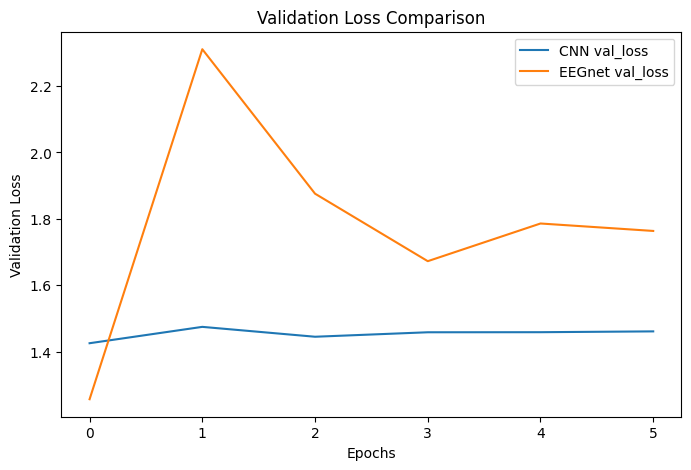

In [32]:
#Validation Loss
plt.figure(figsize=(8,5))

plt.plot(history_cnn.history['val_loss'], label='CNN val_loss')
plt.plot(history_eeg.history['val_loss'], label='EEGnet val_loss')

plt.title('Validation Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.legend()
plt.show()

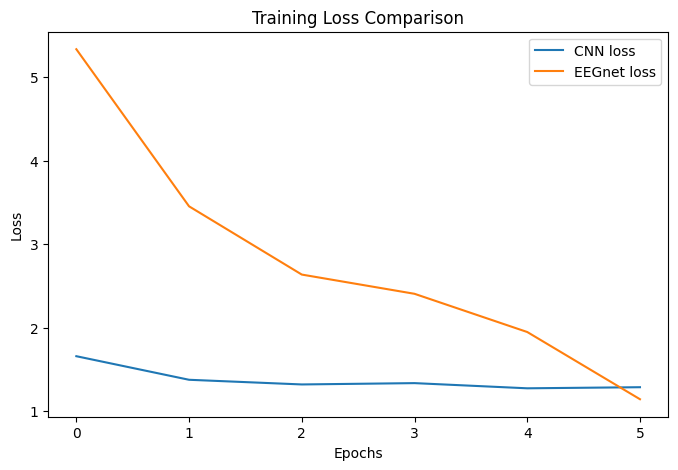

In [33]:
#Loss
plt.figure(figsize=(8,5))

plt.plot(history_cnn.history['loss'], label='CNN loss')
plt.plot(history_eeg.history['loss'], label='EEGnet loss')

plt.title('Training Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

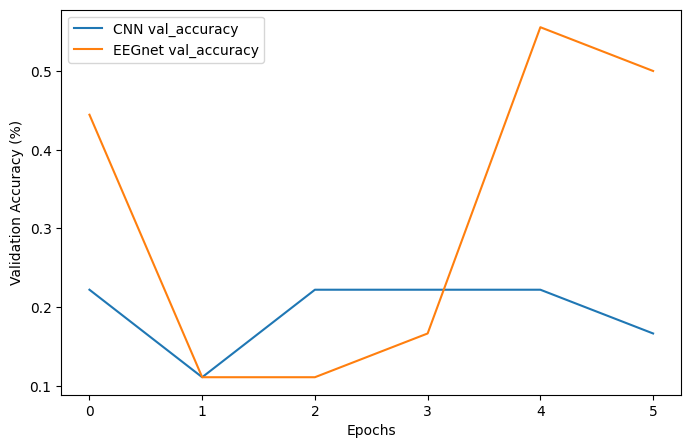

In [34]:
#Validation Accuracy
plt.figure(figsize=(8,5))

plt.plot(history_cnn.history['val_accuracy'], label='CNN val_accuracy')
plt.plot(history_eeg.history['val_accuracy'], label='EEGnet val_accuracy')

plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy (%)')
plt.show()

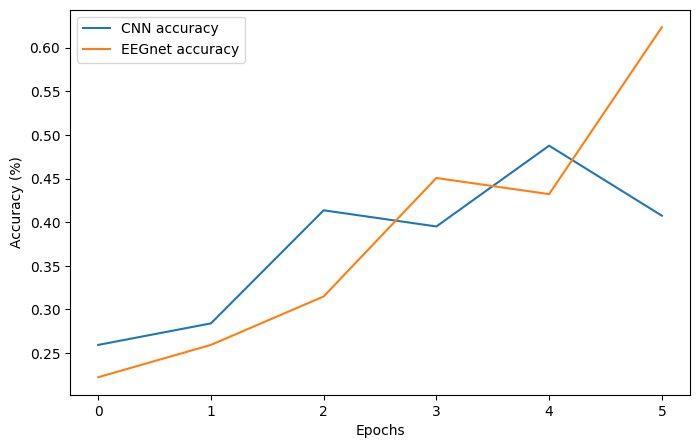

In [35]:
# Accuracy
plt.figure(figsize=(8,5))

plt.plot(history_cnn.history['accuracy'], label='CNN accuracy')
plt.plot(history_eeg.history['accuracy'], label='EEGnet accuracy')

plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.show()

# 4. EEGNet Cross-Validation

In order to determine if an alternative split in the data would yield better training results, we will use Stratified K-fold Cross-Validation to train multiple models and find the best performance possible across a given subject.

In [36]:
# Create a function to train a model 
def fit_evaluate(X_train, X_val,  y_train, y_val, epochs = 50, batch_size = 16): 
    model = EEGNet(input_shape)
    results = model.fit(X_train, y_train, epochs = epochs, batch_size = batch_size, verbose= 1, callbacks=[EarlyStopping, ReduceLR], validation_split = 0.1)
    print("Val Score: ", model.evaluate(X_val, y_val))
    
    return results

In [37]:
n_folds = 5
epochs = 50
batch_size = 16

skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=0)
train_fold = []
val_fold = []
model_history = []

for train_ind, val_ind in skf.split(x_train_cnn, np.argmax(y_train_cnn, axis=1)):
    train_fold.append(train_ind)
    val_fold.append(val_ind)

for i in range(n_folds):
    print("Training on Fold: ", i + 1)
    
    x_train_i = x_train_cnn[train_fold[i]]
    y_train_i = y_train_cnn.values[train_fold[i]] 
    
    x_val_i = x_train_cnn[val_fold[i]]
    y_val_i = y_train_cnn.values[val_fold[i]]
    
    model_history.append(fit_evaluate(x_train_i, x_val_i, y_train_i, y_val_i, epochs = epochs, batch_size = batch_size))
    
    print("=======" * 12, end="\n\n\n")

Training on Fold:  1
Epoch 1/50
8/8 [==============================] - 11s 1s/step - loss: 5.1846 - accuracy: 0.2500 - val_loss: 1.5985 - val_accuracy: 0.3077 - lr: 0.0010
Epoch 2/50
8/8 [==============================] - 9s 1s/step - loss: 2.8686 - accuracy: 0.4052 - val_loss: 1.7036 - val_accuracy: 0.3077 - lr: 0.0010
Epoch 3/50
8/8 [==============================] - 10s 1s/step - loss: 1.8865 - accuracy: 0.4741 - val_loss: 1.3395 - val_accuracy: 0.4615 - lr: 0.0010
Epoch 4/50
8/8 [==============================] - 9s 1s/step - loss: 1.5509 - accuracy: 0.5345 - val_loss: 1.4684 - val_accuracy: 0.1538 - lr: 0.0010
Epoch 5/50
8/8 [==============================] - 9s 1s/step - loss: 1.1928 - accuracy: 0.5948 - val_loss: 1.3019 - val_accuracy: 0.5385 - lr: 0.0010
Epoch 6/50
8/8 [==============================] - 10s 1s/step - loss: 1.1271 - accuracy: 0.6293 - val_loss: 1.3478 - val_accuracy: 0.6154 - lr: 0.0010
Epoch 7/50
8/8 [==============================] - 9s 1s/step - loss: 0.6305 

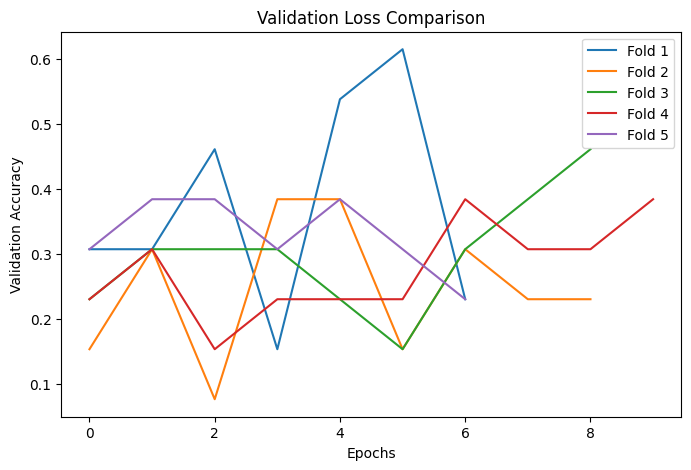

In [38]:
plt.figure(figsize=(8,5))

for i, history in enumerate(model_history):
    plt.plot(history.history['val_accuracy'], label=f'Fold {i+1}')

plt.title('Validation Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.show()

## Results from current project
As can be seen, the current CNN and EEGNet models are unable to avoid rapid overfitting to the training data, and are unable to predict the Direction label of validation data. Although not included in this version of the notebook, it was observed that evaluating both CNN and EEGNet models over the test sets resulted in similar accuracies and losses to the validation set.

Within older versions of this notebook you may also find models trained on data from all 10 subjects (the code looks very similar to this version, as it is hard coded), and models with data augmentation in the training set. Methods for adding k-fold cross validation to the CNN and EEGNet models are also available.

# Further Data Exploration

#### 1. Data Augmentation: Adding Noise to the Data
> In previous versions the models were trained on augmented data with no improvement in performance.

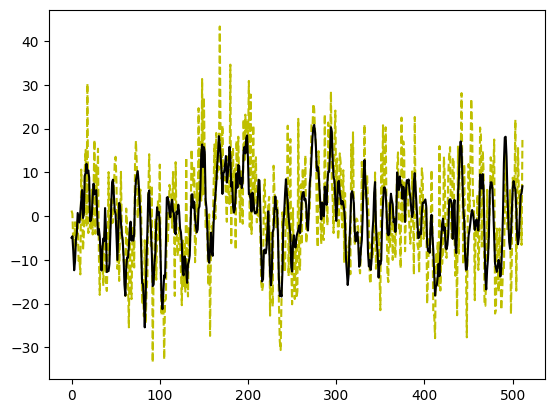

In [39]:
data_shape = x_train_cnn.shape
noise = np.random.normal(loc=0.0, scale=10, size=data_shape)
X_noisy = np.add(x_train_cnn, noise)
plt.plot(X_noisy[1,64,:],'y--');
plt.plot(x_train_cnn[1,64,:], 'k');


#### 2. Data Exploration - Channel Location
Information of channels is partly taken from the Plot_ERPs.py script from Github (https://github.com/N-Nieto/Inner_Speech_Dataset/blob/main/Python_Processing/Plotting/Plot_ERPs.py)

In [40]:
# channel location
Adquisition_eq="biosemi128"
montage = mne.channels.make_standard_montage(Adquisition_eq)
info = mne.create_info(ch_names=X.shape[1], sfreq=256, ch_types='eeg')


In [41]:
mapping = {str(i): ch_name for i, ch_name in enumerate(montage.ch_names)}
info.rename_channels(mapping)

<Info | 7 non-empty values
 bads: []
 ch_names: A1, A2, A3, A4, A5, A6, A7, A8, A9, A10, A11, A12, A13, A14, ...
 chs: 128 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 128.0 Hz
 meas_date: unspecified
 nchan: 128
 projs: []
 sfreq: 256.0 Hz
>

In [42]:
info.set_montage(montage, on_missing='warn')

<Info | 8 non-empty values
 bads: []
 ch_names: A1, A2, A3, A4, A5, A6, A7, A8, A9, A10, A11, A12, A13, A14, ...
 chs: 128 EEG
 custom_ref_applied: False
 dig: 131 items (3 Cardinal, 128 EEG)
 highpass: 0.0 Hz
 lowpass: 128.0 Hz
 meas_date: unspecified
 nchan: 128
 projs: []
 sfreq: 256.0 Hz
>

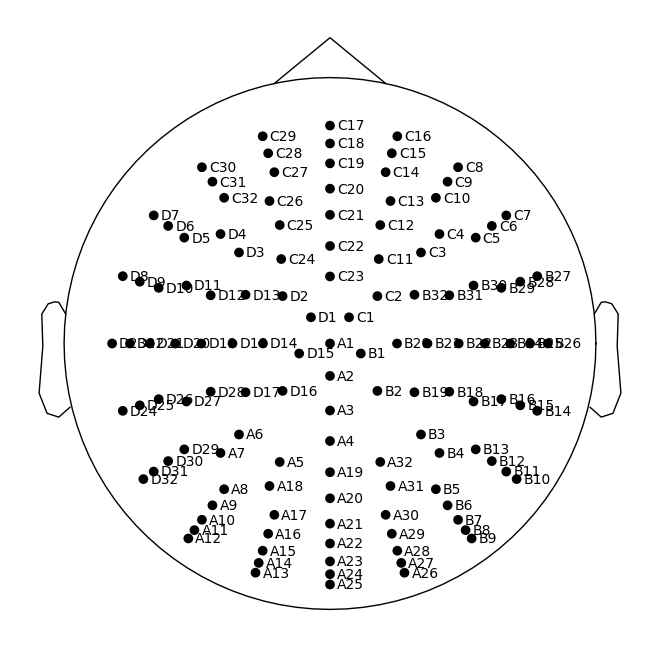

In [43]:
# Create a RawArray object 
raw = mne.io.RawArray(X[1], info)

# Plot the sensors with the applied montage
fig = raw.plot_sensors(show_names=True)

#### 3. Preprocessed EEG Signal

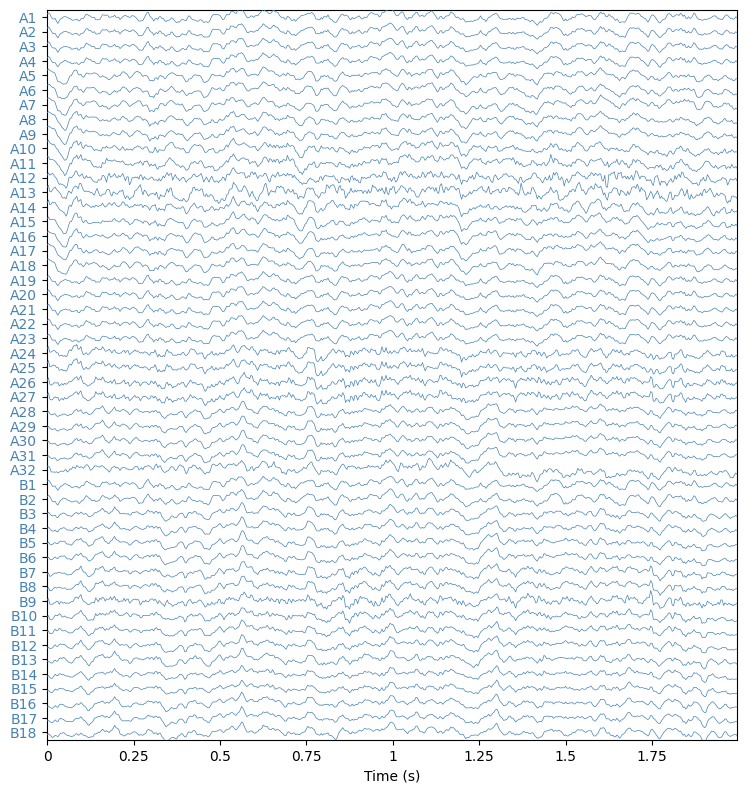

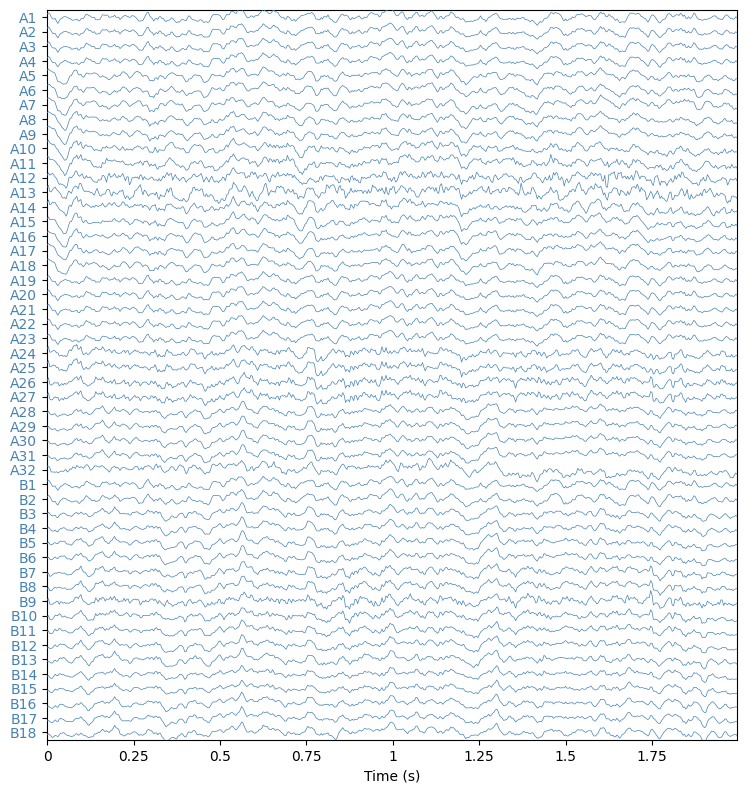

In [44]:
# preprocessed EEG signal - first 50 channels
raw.plot(n_channels=50, color = 'steelblue',show_scrollbars= False, show_scalebars= False, time_format="float")


#### 4. Topoplots

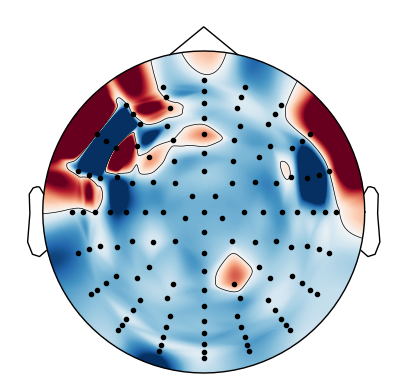

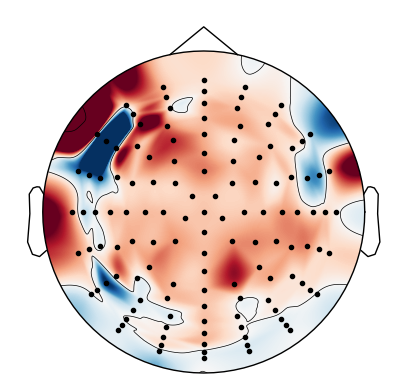

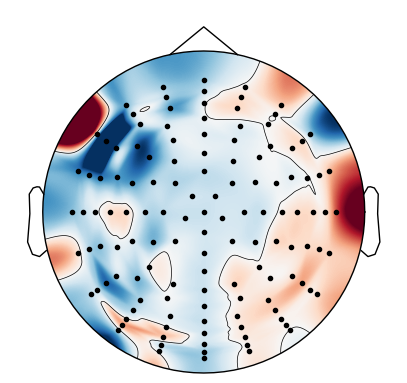

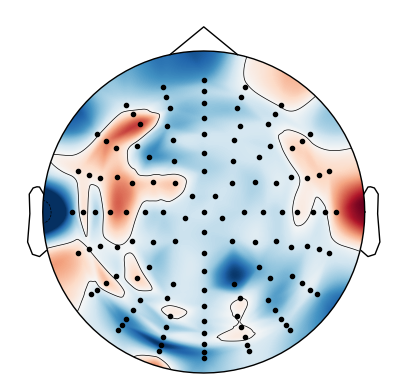

In [45]:
# Topoplots
num_segments = 4
segment_size = raw.n_times // num_segments

# Plot topoplots for each segment
for i in range(num_segments):
    start_idx = i * segment_size
    end_idx = (i + 1) * segment_size if i < num_segments - 1 else raw.n_times
    mean_data = np.mean(raw.get_data()[:, start_idx:end_idx], axis=1)
    
    info = raw.info

    mne.viz.plot_topomap(mean_data, info, show=True, contours= True, res=300, sensors='k.', size=5, vlim =(-0.00001,0.00001))